In [2]:
# -*- coding: utf-8 -*-

# # NFL Betting Model

# packages
import pandas as pd
import numpy as np
import datetime
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    import sklearn

# required machine learning packages
from sklearn import model_selection
from sklearn.feature_selection import RFE
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV as CCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import xgboost as xgb
import pickle
import os

print("Imported!")

Imported!


In [3]:
import xgboost as xgb
xgb.__version__

'3.1.1'

In [5]:
!ls -l


total 14648
-rw-r--r--@ 1 sanchaybhutani  staff    34876 Nov  4 00:07 fml.ipynb
-rw-r--r--@ 1 sanchaybhutani  staff  5776462 Jul 14  2022 nfl_elo.csv
-rw-r--r--@ 1 sanchaybhutani  staff   105027 Jul 14  2022 nfl_elo_latest.csv
-rw-r--r--@ 1 sanchaybhutani  staff     2752 Oct 28 12:43 nfl_teams.csv
-rw-r--r--@ 1 sanchaybhutani  staff  1571835 Oct 28 12:43 spreadspoke_scores.csv


In [6]:

file_path = os.path.dirname(os.path.abspath("__file__"))

# # Loading and Cleaning Data
# loading CSV files downloaded from Kaggle
df = pd.read_csv(file_path + "/spreadspoke_scores.csv", encoding='utf-8')
teams = pd.read_csv(file_path + "/nfl_teams.csv", encoding='utf-8')
games_elo = pd.read_csv(file_path + "/nfl_elo.csv", encoding='utf-8')
#games_elo18 = pd.read_csv(file_path + "\\nfl_games_2019_1.csv", encoding='utf-8')
#games_elo = games_elo.append(games_elo18)

In [7]:
print(df.columns)

Index(['schedule_date', 'schedule_season', 'schedule_week', 'schedule_playoff',
       'team_home', 'score_home', 'score_away', 'team_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line', 'stadium',
       'stadium_neutral', 'weather_temperature', 'weather_wind_mph',
       'weather_humidity', 'weather_detail'],
      dtype='object')


In [8]:
print(teams.columns)

Index(['team_name', 'team_name_short', 'team_id', 'team_id_pfr',
       'team_conference', 'team_division', 'team_conference_pre2002',
       'team_division_pre2002'],
      dtype='object')


In [9]:
print(games_elo.columns)

Index(['date', 'season', 'neutral', 'playoff', 'team1', 'team2', 'elo1_pre',
       'elo2_pre', 'elo_prob1', 'elo_prob2', 'elo1_post', 'elo2_post',
       'qbelo1_pre', 'qbelo2_pre', 'qb1', 'qb2', 'qb1_value_pre',
       'qb2_value_pre', 'qb1_adj', 'qb2_adj', 'qbelo_prob1', 'qbelo_prob2',
       'qb1_game_value', 'qb2_game_value', 'qb1_value_post', 'qb2_value_post',
       'qbelo1_post', 'qbelo2_post', 'score1', 'score2', 'quality',
       'importance', 'total_rating'],
      dtype='object')


In [10]:
# replacing blank strings with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# removing rows from specific columns that have null values, resetting index and changing data types
df = df[(df.score_home.isnull() == False) & (df.team_favorite_id.isnull() == False) & (df.over_under_line.isnull() == False) &
        (df.schedule_season >= 1979)]


In [11]:

df.reset_index(drop=True, inplace=True)
df['over_under_line'] = df.over_under_line.astype(float)

# mapping team_id to the correct teams
df['team_home'] = df.team_home.map(teams.set_index('team_name')['team_id'].to_dict())
df['team_away'] = df.team_away.map(teams.set_index('team_name')['team_id'].to_dict())

In [12]:

# fix team_favorite_id for Colts in 1969 and 1971 SB
df.loc[(df.schedule_season == 1968) & (df.schedule_week == 'Superbowl'), 'team_favorite_id'] = 'IND'
df.loc[(df.schedule_season == 1970) & (df.schedule_week == 'Superbowl'), 'team_favorite_id'] = 'IND'

# creating home favorite and away favorite columns (fill na with 0's)
df.loc[df.team_favorite_id == df.team_home, 'home_favorite'] = 1
df.loc[df.team_favorite_id == df.team_away, 'away_favorite'] = 1
df.home_favorite.fillna(0, inplace=True)
df.away_favorite.fillna(0, inplace=True)

/var/folders/fx/rwrqnvd16p3dzcfy6khs1ts40000gn/T/ipykernel_20856/4087641595.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.home_favorite.fillna(0, inplace=True)
/var/folders/fx/rwrqnvd16p3dzcfy6khs1ts40000gn/T/ipykernel_20856/4087641595.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [14]:
# Correct known mismatches
df['team_favorite_id'] = df['team_favorite_id'].replace({
    'LV': 'LVR',
    'NJY': 'NYJ'
})

# Optionally, turn 'PICK' into NaN or 0
df['team_favorite_id'] = df['team_favorite_id'].replace('PICK', np.nan)


In [15]:
print("Unique team_home IDs:", df['team_home'].unique())
print("Unique team_away IDs:", df['team_away'].unique())
print("Unique team_favorite_id values:", df['team_favorite_id'].unique())


Unique team_home IDs: ['TB' 'BUF' 'CHI' 'DEN' 'KC' 'LAR' 'MIN' 'NO' 'NYJ' 'PHI' 'SEA' 'ARI'
 'WAS' 'NE' 'IND' 'DET' 'GB' 'MIA' 'NYG' 'PIT' 'LAC' 'SF' 'ATL' 'CIN'
 'CLE' 'DAL' 'TEN' 'LVR' 'JAX' 'CAR' 'BAL' 'HOU']
Unique team_away IDs: ['DET' 'MIA' 'GB' 'CIN' 'IND' 'LVR' 'SF' 'ATL' 'CLE' 'NYG' 'LAC' 'DAL'
 'TEN' 'PIT' 'LAR' 'TB' 'MIN' 'WAS' 'NO' 'SEA' 'NYJ' 'ARI' 'DEN' 'NE'
 'CHI' 'KC' 'PHI' 'BUF' 'CAR' 'JAX' 'BAL' 'HOU']
Unique team_favorite_id values: ['TB' 'MIA' 'CHI' 'DEN' 'KC' 'LAR' 'MIN' 'NO' 'NYJ' 'PHI' 'SEA' 'DAL'
 'TEN' 'PIT' nan 'CIN' 'GB' 'NE' 'ARI' 'LAC' 'CLE' 'WAS' 'BUF' 'ATL' 'LVR'
 'IND' 'DET' 'NYG' 'SF' 'BAL' 'JAX' 'CAR' 'HOU']


In [16]:
# creating over / under column (fill na with 0's)
df.loc[((df.score_home + df.score_away) > df.over_under_line), 'over'] = 1
df.over.fillna(0, inplace=True)

# stadium neutral and schedule playoff as boolean
df['stadium_neutral'] = df.stadium_neutral.astype(int)
df['schedule_playoff'] = df.schedule_playoff.astype(int)

# change data type of date columns
df['schedule_date'] = pd.to_datetime(df['schedule_date'])
games_elo['date'] = pd.to_datetime(games_elo['date'])

/var/folders/fx/rwrqnvd16p3dzcfy6khs1ts40000gn/T/ipykernel_20856/33004885.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.over.fillna(0, inplace=True)


In [17]:


# fixing some schedule_week column errors and converting column to integer data type
df.loc[(df.schedule_week == '18'), 'schedule_week'] = '17'
df.loc[(df.schedule_week == 'Wildcard') | (df.schedule_week == 'WildCard'), 'schedule_week'] = '18'
df.loc[(df.schedule_week == 'Division'), 'schedule_week'] = '19'
df.loc[(df.schedule_week == 'Conference'), 'schedule_week'] = '20'
df.loc[(df.schedule_week == 'Superbowl') | (df.schedule_week == 'SuperBowl'), 'schedule_week'] = '21'
df['schedule_week'] = df.schedule_week.astype(int)

In [18]:

# removing extra columns that aren't necessary for analysis
df = df[['schedule_date', 'schedule_season', 'schedule_week', 'team_home',
       'team_away', 'team_favorite_id', 'spread_favorite',
       'over_under_line', 'weather_temperature',
       'weather_wind_mph', 'score_home', 'score_away',
       'stadium_neutral', 'home_favorite', 'away_favorite',
       'over']]

# Cleaning games_elo and df to merge correctly
wsh_map = {'WSH' : 'WAS'}
games_elo.loc[games_elo.team1 == 'WSH', 'team1'] = 'WAS' 
games_elo.loc[games_elo.team2 == 'WSH', 'team2'] = 'WAS'

In [19]:

# fix dates
df.loc[(df.schedule_date == '2016-09-19') & (df.team_home == 'MIN'), 'schedule_date'] = datetime.datetime(2016, 9, 18)
df.loc[(df.schedule_date == '2017-01-22') & (df.schedule_week == 21), 'schedule_date'] = datetime.datetime(2017, 2, 5)
df.loc[(df.schedule_date == '1990-01-27') & (df.schedule_week == 21), 'schedule_date'] = datetime.datetime(1990, 1, 28)
df.loc[(df.schedule_date == '1990-01-13'), 'schedule_date'] = datetime.datetime(1990, 1, 14)
games_elo.loc[(games_elo.date == '2016-01-09'), 'date'] = datetime.datetime(2016, 1, 10)
games_elo.loc[(games_elo.date == '2016-01-08'), 'date'] = datetime.datetime(2016, 1, 9)
games_elo.loc[(games_elo.date == '2016-01-16'), 'date'] = datetime.datetime(2016, 1, 17)
games_elo.loc[(games_elo.date == '2016-01-15'), 'date'] = datetime.datetime(2016, 1, 16)

In [25]:
import pandas as pd
from datetime import timedelta

# Ensure proper datetime types
df['schedule_date'] = pd.to_datetime(df['schedule_date'])
games_elo['date'] = pd.to_datetime(games_elo['date'])

# Filter for post-1979 games
df_recent = df[df['schedule_season'] >= 1979].copy()
games_recent = games_elo[games_elo['season'] >= 1979].copy()

# Merge to check matches
merged = df_recent.merge(
    games_recent,
    left_on=['schedule_date', 'team_home', 'team_away'],
    right_on=['date', 'team1', 'team2'],
    how='outer',
    indicator=True
)

# Identify potential mismatches (i.e., not matched by exact date)
mismatched = merged[merged['_merge'] != 'both']

# Detect near matches (same teams, date off by ±1 day)
def near_match(row):
    if pd.notnull(row.get('schedule_date')) and pd.notnull(row.get('date')):
        delta = abs((row['schedule_date'] - row['date']).days)
        return (delta <= 1) and (row['team_home'] == row['team1']) and (row['team_away'] == row['team2'])
    return False

near_matches = mismatched[mismatched.apply(near_match, axis=1)]

print("⚠️ Near matches (date offset ≤ 1 day):")
print(near_matches[['schedule_season', 'schedule_date', 'date', 'team_home', 'team_away']].sort_values('schedule_season').head(15))

print("\n🔍 Total near matches found:", len(near_matches))
print("🔹 Total mismatches (any kind):", len(mismatched))


⚠️ Near matches (date offset ≤ 1 day):
Empty DataFrame
Columns: [schedule_season, schedule_date, date, team_home, team_away]
Index: []

🔍 Total near matches found: 0
🔹 Total mismatches (any kind): 2535


In [26]:
reversed_matches = df.merge(
    games_elo,
    left_on=['schedule_date', 'team_home', 'team_away'],
    right_on=['date', 'team2', 'team1'],
    how='inner'
)

print("🏠 Away-home reversed matches:", len(reversed_matches))


🏠 Away-home reversed matches: 30


In [ ]:
# merge games_elo with df
df = df.merge(games_elo, left_on=['schedule_date', 'team_home', 'team_away'], right_on=['date', 'team1', 'team2'], how='left')

# merge to fix neutral games where team_home and team_away are switched
games_elo2 = games_elo.rename(columns={'team1' : 'team2', 'team2' : 'team1', 'elo1_pre' : 'elo2_pre', 'elo2_pre' : 'elo1_pre'})
games_elo2['qbelo_prob1'] = 1 - games_elo2.qbelo_prob1
df = df.merge(games_elo2, left_on=['schedule_date', 'team_home', 'team_away'], right_on=['date', 'team1', 'team2'], how='left')


In [28]:

# separating merged columns into x and y cols
x_cols = ['date_x', 'season_x', 'neutral_x', 'playoff_x', 'team1_x', 'team2_x', 'elo1_pre_x', 'elo2_pre_x',
          'qbelo_prob1_x', 'score1_x', 'score2_x']
y_cols = ['date_y', 'season_y', 'neutral_y', 'playoff_y', 'team1_y', 'team2_y', 'elo1_pre_y', 'elo2_pre_y',
          'qbelo_prob1_y', 'score1_y', 'score2_y']

# filling null values for games_elo merged cols
for x, y in zip(x_cols, y_cols):
    df[x] = df[x].fillna(df[y]) 

# removing y_cols from dataframe    
df = df[['schedule_date', 'schedule_season', 'schedule_week', 'team_home',
       'team_away', 'team_favorite_id', 'spread_favorite', 'over_under_line',
       'weather_temperature', 'weather_wind_mph', 'score_home', 'score_away',
       'stadium_neutral', 'home_favorite', 'away_favorite', 'over', 'neutral_x', 'playoff_x',
         'elo1_pre_x', 'elo2_pre_x', 'qbelo_prob1_x']]

# remove _x ending from column names
df.columns = df.columns.str.replace('_x', '')

In [29]:

# creating result column df.loc[(df.score_home > df.score_away), 'result'
df['result'] = (df.score_home > df.score_away).astype(int)


# # Data Exploration

# all column names
print(df.columns)


# snapshot of data
print(df.head(10))


# null values by column
print(df.isnull().sum(axis=0))


# summary statistics
df.describe().transpose()

Index(['schedule_date', 'schedule_season', 'schedule_week', 'team_home',
       'team_away', 'team_favorite_id', 'spread_favorite', 'over_under_line',
       'weather_temperature', 'weather_wind_mph', 'score_home', 'score_away',
       'stadium_neutral', 'home_favorite', 'away_favorite', 'over', 'neutral',
       'playoff', 'elo1_pre', 'elo2_pre', 'qbelo_prob1', 'result'],
      dtype='object')
  schedule_date  schedule_season  schedule_week team_home team_away  \
0    1979-09-01             1979              1        TB       DET   
1    1979-09-02             1979              1       BUF       MIA   
2    1979-09-02             1979              1       CHI        GB   
3    1979-09-02             1979              1       DEN       CIN   
4    1979-09-02             1979              1        KC       IND   
5    1979-09-02             1979              1       LAR       LVR   
6    1979-09-02             1979              1       MIN        SF   
7    1979-09-02             1979  

,count,mean,min,25%,50%,75%,max,std
schedule_date,11644,2003-10-10 09:56:27.289591040,1979-09-01 00:00:00,1992-10-23 12:00:00,2003-12-28 00:00:00,2014-12-14 00:00:00,2025-10-28 00:00:00,NaN
schedule_season,11644.0,2002.926314,1979.0,1992.0,2003.0,2014.0,2025.0,13.219254
schedule_week,11644.0,9.405015,1.0,5.0,10.0,14.0,21.0,5.231249
spread_favorite,11644.0,-5.348377,-26.5,-7.0,-4.5,-3.0,0.0,3.427067
over_under_line,11644.0,42.371496,28.0,39.0,42.0,45.5,68.0,4.796504
weather_temperature,10396.0,60.330127,-6.0,50.0,65.0,72.0,97.0,15.392023
weather_wind_mph,10380.0,6.970135,0.0,0.0,7.0,11.0,40.0,5.782924
score_home,11644.0,22.825232,0.0,16.0,23.0,30.0,70.0,10.351212
score_away,11644.0,20.181037,0.0,13.0,20.0,27.0,59.0,10.036883
stadium_neutral,11644.0,0.009705,0.0,0.0,0.0,0.0,1.0,0.098037


In [30]:

# some percentages to take into consideration when betting
home_win = "{:.2f}".format((sum((df.result == 1) & (df.stadium_neutral == 0)) / len(df)) * 100)
away_win = "{:.2f}".format((sum((df.result == 0) & (df.stadium_neutral == 0)) / len(df)) * 100)
under_line = "{:.2f}".format((sum((df.score_home + df.score_away) < df.over_under_line) / len(df)) * 100)
over_line = "{:.2f}".format((sum((df.score_home + df.score_away) > df.over_under_line) / len(df)) * 100)

favored = "{:.2f}".format((sum(((df.home_favorite == 1) & (df.result == 1)) | ((df.away_favorite == 1) & (df.result == 0)))
                           / len(df)) * 100)

cover = "{:.2f}".format((sum(((df.home_favorite == 1) & ((df.score_away - df.score_home) < df.spread_favorite)) | 
                             ((df.away_favorite == 1) & ((df.score_home - df.score_away) < df.spread_favorite))) 
                         / len(df)) * 100)

ats = "{:.2f}".format((sum(((df.home_favorite == 1) & ((df.score_away - df.score_home) > df.spread_favorite)) | 
                           ((df.away_favorite == 1) & ((df.score_home - df.score_away) > df.spread_favorite))) 
                       / len(df)) * 100)


# print all percentages
print("Number of Games: " + str(len(df)))
print("Home Straight Up Win Percentage: " + home_win + "%")
print("Away Straight Up Win Percentage: " + away_win + "%")
print("Under Percentage: " + under_line + "%")
print("Over Percentage: " + over_line + "%")
print("Favored Win Percentage: " + favored + "%")
print("Cover The Spread Percentage: " + cover + "%")
print("Against The Spread Percentage: " + ats + "%")

Number of Games: 11644
Home Straight Up Win Percentage: 56.92%
Away Straight Up Win Percentage: 42.11%
Under Percentage: 49.86%
Over Percentage: 48.29%
Favored Win Percentage: 65.42%
Cover The Spread Percentage: 46.62%
Against The Spread Percentage: 49.31%


In [32]:
print(df[['score_home','score_away']].dtypes)


score_home    float64
score_away    float64
dtype: object


In [33]:
print(df[['schedule_season','schedule_week','team_home']].dtypes)


schedule_season     int64
schedule_week       int64
team_home          object
dtype: object


In [ ]:
# # Creating More Features
# Features that will help predict whether the home team will win (straight up win in the current version the line doesn't matter)

# creating 2 separate dataframes with the home teams / scores and the away teams / scores
score = df.groupby(['schedule_season', 'schedule_week', 'team_home']).mean()[['score_home', 'score_away']].reset_index()
aw_score = df.groupby(['schedule_season', 'schedule_week', 'team_away']).mean()[['score_home', 'score_away']].reset_index()

# create total pts column
score['point_diff'] = score.score_home - score.score_away
aw_score['point_diff'] = aw_score.score_away - aw_score.score_home

# append the two dataframes
score = score.append(aw_score, ignore_index=True, sort=True)

# fill null values
score.team_home.fillna(score.team_away, inplace=True)

# sort by season and week 
score.sort_values(['schedule_season', 'schedule_week'], ascending = [True, True], inplace=True)

# removing unneeded columns & changing column name 
score = score[['schedule_season', 'schedule_week', 'team_home', 'point_diff']]
score.rename(columns={'team_home' : 'team'}, inplace=True)
 
# dictionary of dataframes - separate dataframe for each team
tm_dict = {}
for key in score.team.unique():
    tm_dict[key] = score[score.team == key].reset_index(drop=True)

TypeError: agg function failed [how->mean,dtype->object]

In [35]:
# select numeric columns for aggregation
numeric_cols = ['score_home', 'score_away']

# home scores grouped by season, week, team_home
score = df[['schedule_season', 'schedule_week', 'team_home'] + numeric_cols].groupby(
    ['schedule_season', 'schedule_week', 'team_home']
)[numeric_cols].mean().reset_index()

# away scores grouped by season, week, team_away
aw_score = df[['schedule_season', 'schedule_week', 'team_away'] + numeric_cols].groupby(
    ['schedule_season', 'schedule_week', 'team_away']
)[numeric_cols].mean().reset_index()

# create point_diff
score['point_diff'] = score['score_home'] - score['score_away']
aw_score['point_diff'] = aw_score['score_away'] - aw_score['score_home']

# rename away column to match home column for concat
aw_score.rename(columns={'team_away': 'team_home'}, inplace=True)

# combine home and away data
score = pd.concat([score, aw_score], ignore_index=True, sort=False)

# keep only relevant columns
score = score[['schedule_season', 'schedule_week', 'team_home', 'point_diff']]

# rename column to 'team'
score.rename(columns={'team_home': 'team'}, inplace=True)

# sort by season and week
score.sort_values(['schedule_season', 'schedule_week'], ascending=[True, True], inplace=True)

# create dictionary of DataFrames per team
tm_dict = {team: df_team.reset_index(drop=True) for team, df_team in score.groupby('team')}


In [36]:
# dataframe to populate
pts_diff_list = []

# for loop to create a rolling average of the previous games for each season
for yr in score.schedule_season.unique():
    for tm in score.team.unique():
        data = tm_dict[tm].copy()
        data = data[data.schedule_season == yr]
        
        data['avg_pts_diff'] = data.point_diff.shift().expanding().mean()
        
        pts_diff_list.append(data)

# combine all into one dataframe
pts_diff = pd.concat(pts_diff_list, ignore_index=True, sort=False)

# merging to df and changing column names
df = df.merge(
    pts_diff[['schedule_season', 'schedule_week', 'team', 'avg_pts_diff']], 
    left_on=['schedule_season', 'schedule_week', 'team_home'], 
    right_on=['schedule_season', 'schedule_week', 'team'],
    how='left'
)
df.rename(columns={'avg_pts_diff' : 'hm_avg_pts_diff'}, inplace=True)

df = df.merge(
    pts_diff[['schedule_season', 'schedule_week', 'team', 'avg_pts_diff']], 
    left_on=['schedule_season', 'schedule_week', 'team_away'], 
    right_on=['schedule_season', 'schedule_week', 'team'],
    how='left'
)
df.rename(columns={'avg_pts_diff' : 'aw_avg_pts_diff'}, inplace=True)


In [38]:
# average point differential over entire season
total_season = pts_diff.groupby(['schedule_season', 'team']).mean()['point_diff'].reset_index()


# adding schedule week for merge and adding one to the season for predictions
total_season['schedule_week'] = 1
total_season['schedule_season'] += 1


# differentials for start of the year
# total_season.to_csv("pointdiff2019.csv", index=False)


# cleaning of columns
df = df[['schedule_date', 'schedule_season', 'schedule_week', 'team_home',
       'team_away', 'team_favorite_id', 'spread_favorite', 'over_under_line',
       'weather_temperature', 'weather_wind_mph', 'score_home', 'score_away', 'stadium_neutral', 'home_favorite',
       'away_favorite', 'hm_avg_pts_diff','aw_avg_pts_diff', 'elo1_pre', 'elo2_pre', 'qbelo_prob1', 'over', 'result']]


# merge to have previous seasons average point differential
df = df.merge(total_season[['schedule_season', 'schedule_week', 'team', 'point_diff']], 
              left_on=['schedule_season', 'schedule_week', 'team_home'], right_on=['schedule_season', 'schedule_week', 'team'],
              how='left')

df.rename(columns={'point_diff' : 'hm_avg_diff'}, inplace=True)

df = df.merge(total_season[['schedule_season', 'schedule_week', 'team', 'point_diff']], 
              left_on=['schedule_season', 'schedule_week', 'team_away'], right_on=['schedule_season', 'schedule_week', 'team'],
              how='left')
df.rename(columns={'point_diff' : 'aw_avg_diff'}, inplace=True)


In [39]:
# fill null values
df.hm_avg_pts_diff.fillna(df.hm_avg_diff, inplace=True)
df.aw_avg_pts_diff.fillna(df.aw_avg_diff, inplace=True)


# cleaning of columns
df = df[['schedule_date', 'schedule_season', 'schedule_week', 'team_home',
       'team_away', 'team_favorite_id', 'spread_favorite', 'over_under_line',
       'weather_temperature', 'weather_wind_mph', 'score_home', 'score_away', 'stadium_neutral', 'home_favorite',
       'away_favorite', 'hm_avg_pts_diff','aw_avg_pts_diff', 'elo1_pre', 'elo2_pre', 'qbelo_prob1', 'over', 'result']]


# removing all rows with null values
df = df.dropna(how='any',axis=0) 

/var/folders/fx/rwrqnvd16p3dzcfy6khs1ts40000gn/T/ipykernel_20856/1603620853.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.hm_avg_pts_diff.fillna(df.hm_avg_diff, inplace=True)
/var/folders/fx/rwrqnvd16p3dzcfy6khs1ts40000gn/T/ipykernel_20856/1603620853.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

In [41]:

# # Feature and Model Testing 

# initial features possible for model
X = df[['schedule_season', 'schedule_week', 'over_under_line', 'spread_favorite', 'weather_temperature', 'weather_wind_mph',
        'home_favorite', 'hm_avg_pts_diff','aw_avg_pts_diff', 'elo1_pre', 'elo2_pre', 'qbelo_prob1']]

y = df['result']


# base model
base = LDA()

# choose 5 best features
rfe = RFE(estimator=base, n_features_to_select=5)
rfe = rfe.fit(X, y)

# features
print(rfe.support_)
print(rfe.ranking_)


# best 5 features chosen by the RFE base model
final_x = df[['spread_favorite', 'home_favorite', 'hm_avg_pts_diff', 'elo2_pre', 'qbelo_prob1']]



[False False False  True False  True  True  True False False False  True]
[5 6 2 1 4 1 1 1 3 7 8 1]


In [42]:
# prepare models
models = []

models.append(('LRG', LogisticRegression(solver='liblinear')))
models.append(('KNB', KNeighborsClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('XGB', xgb.XGBClassifier(random_state=0)))
models.append(('RFC', RandomForestClassifier(random_state=0, n_estimators=100)))
models.append(('DTC', DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=5)))

# evaluate each model by average and standard deviations of roc auc 
results = []
names = []

for name, m in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
    cv_results = model_selection.cross_val_score(m, final_x, y, cv=kfold, scoring = 'roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LRG: 0.696232 (0.005131)
KNB: 0.635206 (0.009526)
GNB: 0.694663 (0.005392)
XGB: 0.658529 (0.010115)
RFC: 0.679623 (0.010613)
DTC: 0.693537 (0.007599)


In [43]:

# training and testing data (2017 and 2018)
train = df.copy()
test = df.copy()
train = train.loc[train['schedule_season'] < 2017]
test = test.loc[test['schedule_season'] > 2016]
X_train = train[['over_under_line', 'spread_favorite', 'home_favorite', 'hm_avg_pts_diff', 'qbelo_prob1']]
y_train = train['result']
X_test = test[['over_under_line', 'spread_favorite', 'home_favorite', 'hm_avg_pts_diff', 'qbelo_prob1']]
y_test = test['result']

# calibrate probabilities and fit model to training data
boost = xgb.XGBClassifier()
dtc = DecisionTreeClassifier(max_depth=5, criterion='entropy')
lrg = LogisticRegression(solver='liblinear')
vote = VotingClassifier(estimators=[('boost', boost), ('dtc', dtc), ('lrg', lrg)], voting='soft')

model = CCV(vote, method='isotonic', cv=3)
model.fit(X_train, y_train)

# predict probabilities
predicted = model.predict_proba(X_test)[:,1]

In [44]:
# # Results
# ROC AUC Score higher is better while Brier Score the lower the better
print("Metrics" + "\t\t" + "My Model" + "\t" + "Elo Results")
print("ROC AUC Score: " +  "\t" + "{:.4f}".format(roc_auc_score(y_test, predicted)) + "\t\t" + "{:.4f}".format(roc_auc_score(test.result, test.qbelo_prob1)))
print("Brier Score: " + "\t" + "{:.4f}".format(brier_score_loss(y_test, predicted)) + "\t\t" + "{:.4f}".format(brier_score_loss(test.result, test.qbelo_prob1)))

# creating a column with the models probabilities to analyze vs elo fivethirtyeight
test.loc[:,'hm_prob'] = predicted
test = test[['schedule_season', 'schedule_week', 'team_home', 'team_away', 'qbelo_prob1', 'hm_prob', 'result']]

# calulate bets won (only make a bet when probability is greater than / equal to 60% or less than / equal to 40%)
test['my_bet_won'] = (((test.hm_prob >= 0.60) & (test.result == 1)) | ((test.hm_prob <= 0.40) & (test.result == 0))).astype(int)
test['elo_bet_won'] = (((test.qbelo_prob1 >= 0.60) & (test.result == 1)) | ((test.qbelo_prob1 <= 0.40) & (test.result == 0))).astype(int)

# calulate bets lost (only make a bet when probability is greater than / equal to 60% or less than / equal to 40%)
test['my_bet_lost'] = (((test.hm_prob >= 0.60) & (test.result == 0)) | ((test.hm_prob <= 0.40) & (test.result == 1))).astype(int)
test['elo_bet_lost'] = (((test.qbelo_prob1 >= 0.60) & (test.result == 0)) | ((test.qbelo_prob1 <= 0.40) & (test.result == 1))).astype(int)

# printing some quick overall results for my model
print("My Model Win Percentage: " + "{:.4f}".format(test.my_bet_won.sum() / (test.my_bet_lost.sum() + test.my_bet_won.sum())))
print("Total Number of Bets Won: " + str(test.my_bet_won.sum()))
print("Total Number of Bets Made: " + str((test.my_bet_lost.sum() + test.my_bet_won.sum())))
print("Possible Games: " + str(len(test)))

# printing some quick overall results for fivethirtyeight's ELO model
print("ELO Model Win Percentage: " + "{:.4f}".format(test.elo_bet_won.sum()/(test.elo_bet_lost.sum() + test.elo_bet_won.sum())))
print("Total Number of Bets Won: " + str(test.elo_bet_won.sum()))
print("Total Number of Bets Made: " + str((test.elo_bet_lost.sum() + test.elo_bet_won.sum())))
print("Possible Games: " + str(len(test)))

# creating week by week results
results_df = test.groupby(['schedule_season', 'schedule_week']).agg({'team_home' : 'count', 'my_bet_won' : 'sum', 
'elo_bet_won' : 'sum', 'my_bet_lost' : 'sum', 'elo_bet_lost' : 'sum'}).reset_index().rename(columns=
                                                                                            {'team_home' : 'total_games'})

# counting total bets for my model and the ELO model (prob >= 60% or prob <= 40%)
results_df['total_bets'] = results_df.my_bet_won + results_df.my_bet_lost
results_df['elo_total_bets'] = results_df.elo_bet_won + results_df.elo_bet_lost

# creating accuracy columns based on bets made not on total games
results_df['bet_accuracy'] = round((results_df.my_bet_won / results_df.total_bets) * 100, 2)
results_df['elo_bet_accuracy'] = round((results_df.elo_bet_won / results_df.elo_total_bets) * 100, 2)
results_df = results_df[['schedule_season', 'schedule_week', 'bet_accuracy', 'elo_bet_accuracy',
                         'total_bets', 'elo_total_bets', 'total_games']]


print(results_df)

Metrics		My Model	Elo Results
ROC AUC Score: 	0.7188		0.7029
Brier Score: 	0.2139		0.2169
My Model Win Percentage: 0.7186
Total Number of Bets Won: 447
Total Number of Bets Made: 622
Possible Games: 866
ELO Model Win Percentage: 0.6930
Total Number of Bets Won: 404
Total Number of Bets Made: 583
Possible Games: 866
     schedule_season  schedule_week  bet_accuracy  elo_bet_accuracy  \
0               2017              1         70.00             77.78   
1               2017              2         87.50            100.00   
2               2017              3         60.00             55.56   
3               2017              4         60.00             70.00   
4               2017              5         50.00             60.00   
..               ...            ...           ...               ...   
99              2021             17         82.05             74.29   
100             2021             18         80.00             80.00   
101             2021             19         

In [46]:
# create week by week results
results_norm = test.groupby(['schedule_season', 'schedule_week']).agg({
    'team_home': 'count',
    'my_bet_won': 'sum', 
    'elo_bet_won': 'sum', 
    'my_bet_lost': 'sum', 
    'elo_bet_lost': 'sum'
}).reset_index().rename(columns={'team_home': 'total_games'})

# counting total bets for my model and the ELO model
results_norm['total_bets'] = results_norm.my_bet_won + results_norm.my_bet_lost
results_norm['elo_total_bets'] = results_norm.elo_bet_won + results_norm.elo_bet_lost

# creating accuracy columns based on bets made (avoid NaN for 0 bets)
results_norm['bet_accuracy'] = round(
    results_norm.apply(lambda row: (row.my_bet_won / row.total_bets * 100) if row.total_bets > 0 else 0, axis=1), 2
)
results_norm['elo_bet_accuracy'] = round(
    results_norm.apply(lambda row: (row.elo_bet_won / row.elo_total_bets * 100) if row.elo_total_bets > 0 else 0, axis=1), 2
)

# keep desired columns
results_norm = results_norm[['schedule_season', 'schedule_week', 'bet_accuracy', 'elo_bet_accuracy',
                             'total_bets', 'elo_total_bets', 'total_games']]

print(results_norm)


     schedule_season  schedule_week  bet_accuracy  elo_bet_accuracy  \
0               2017              1         70.00             77.78   
1               2017              2         87.50            100.00   
2               2017              3         60.00             55.56   
3               2017              4         60.00             70.00   
4               2017              5         50.00             60.00   
..               ...            ...           ...               ...   
99              2021             17         82.05             74.29   
100             2021             18         80.00             80.00   
101             2021             19         50.00             25.00   
102             2021             20         50.00             50.00   
103             2021             21        100.00            100.00   

     total_bets  elo_total_bets  total_games  
0            10               9           14  
1             8               6           13  
2     

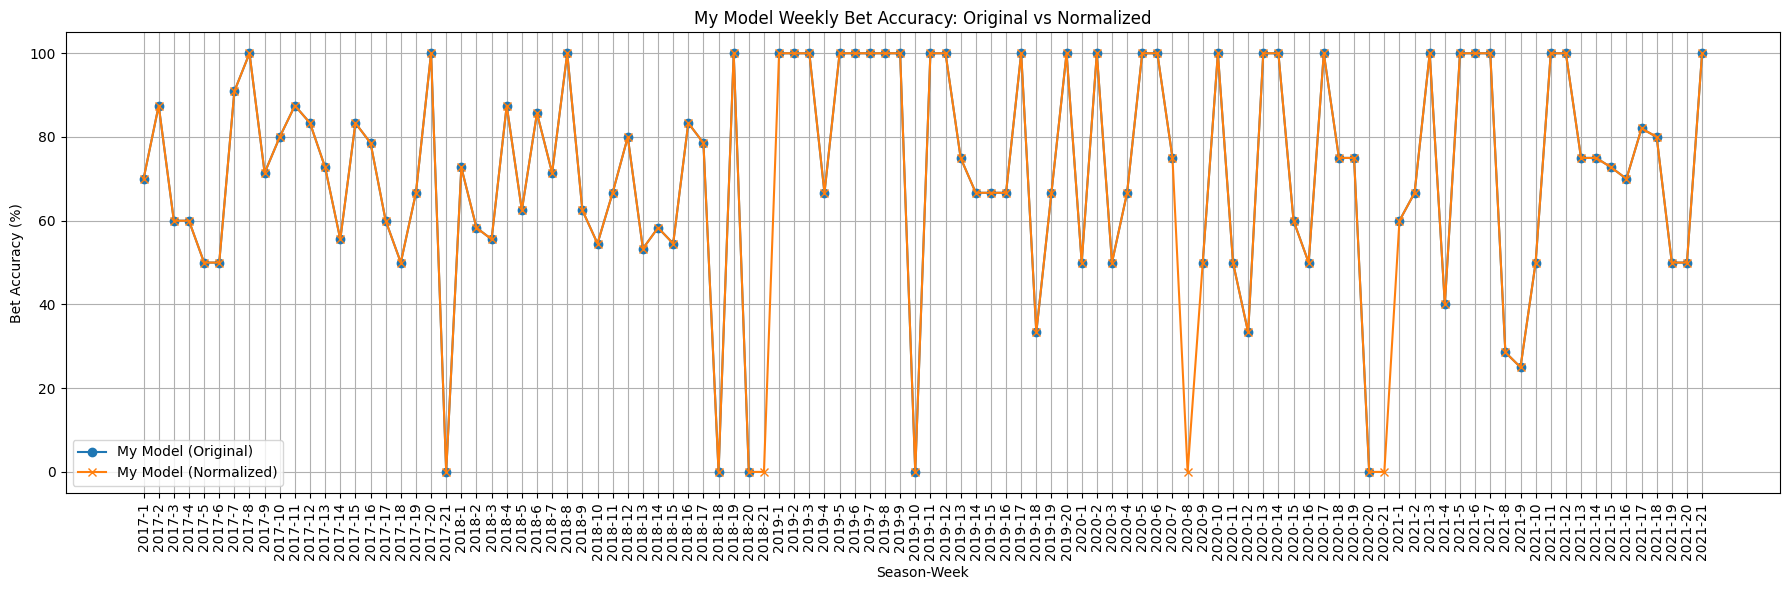

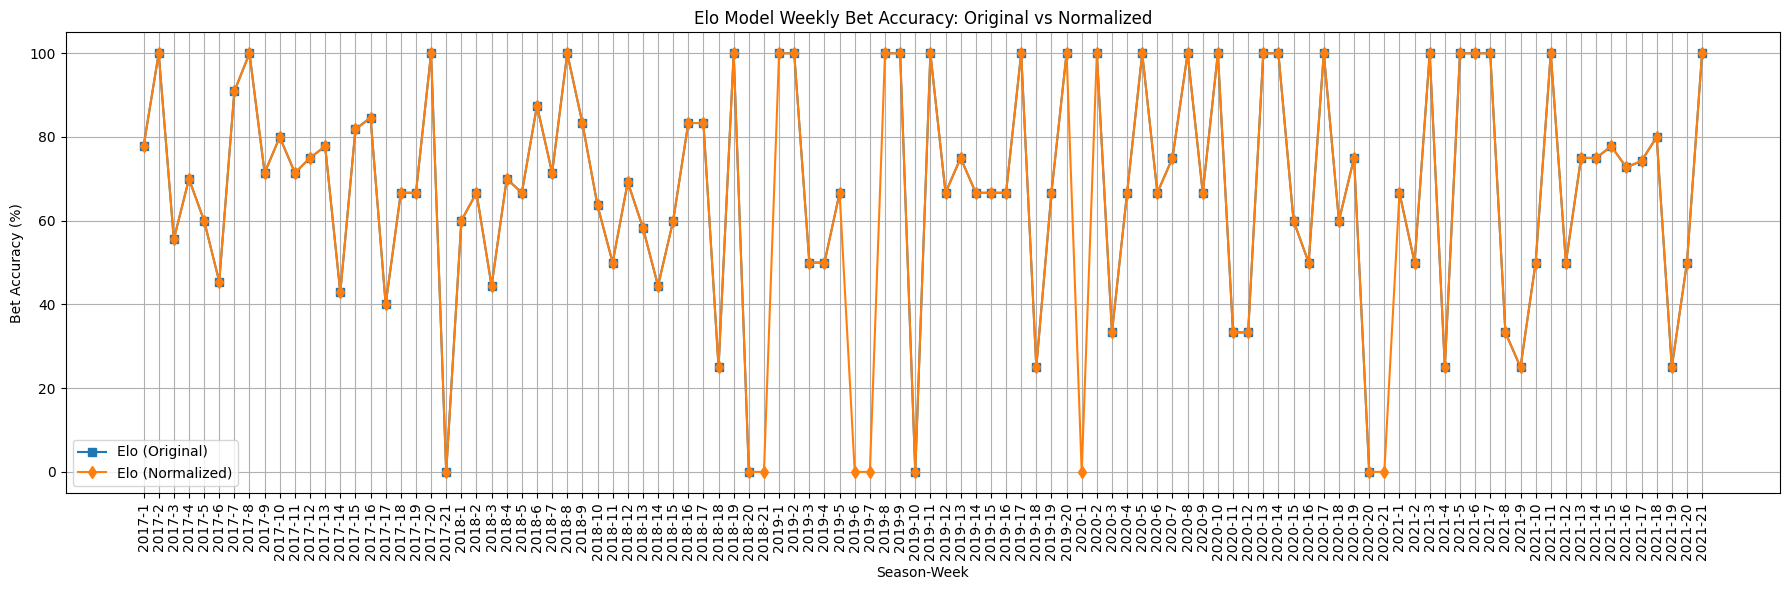

In [48]:
import matplotlib.pyplot as plt

# merge the two dataframes for comparison
comparison = results_df.merge(
    results_norm,
    on=['schedule_season', 'schedule_week'],
    suffixes=('_old', '_norm')
)

# create x-axis labels as "season-week"
comparison['season_week'] = comparison['schedule_season'].astype(str) + '-' + comparison['schedule_week'].astype(str)

# --- Chart 1: My Model Accuracy ---
plt.figure(figsize=(18,6))
plt.plot(comparison['season_week'], comparison['bet_accuracy_old'], label='My Model (Original)', marker='o')
plt.plot(comparison['season_week'], comparison['bet_accuracy_norm'], label='My Model (Normalized)', marker='x')
plt.xticks(rotation=90)
plt.xlabel('Season-Week')
plt.ylabel('Bet Accuracy (%)')
plt.title('My Model Weekly Bet Accuracy: Original vs Normalized')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Chart 2: Elo Model Accuracy ---
plt.figure(figsize=(18,6))
plt.plot(comparison['season_week'], comparison['elo_bet_accuracy_old'], label='Elo (Original)', marker='s')
plt.plot(comparison['season_week'], comparison['elo_bet_accuracy_norm'], label='Elo (Normalized)', marker='d')
plt.xticks(rotation=90)
plt.xlabel('Season-Week')
plt.ylabel('Bet Accuracy (%)')
plt.title('Elo Model Weekly Bet Accuracy: Original vs Normalized')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


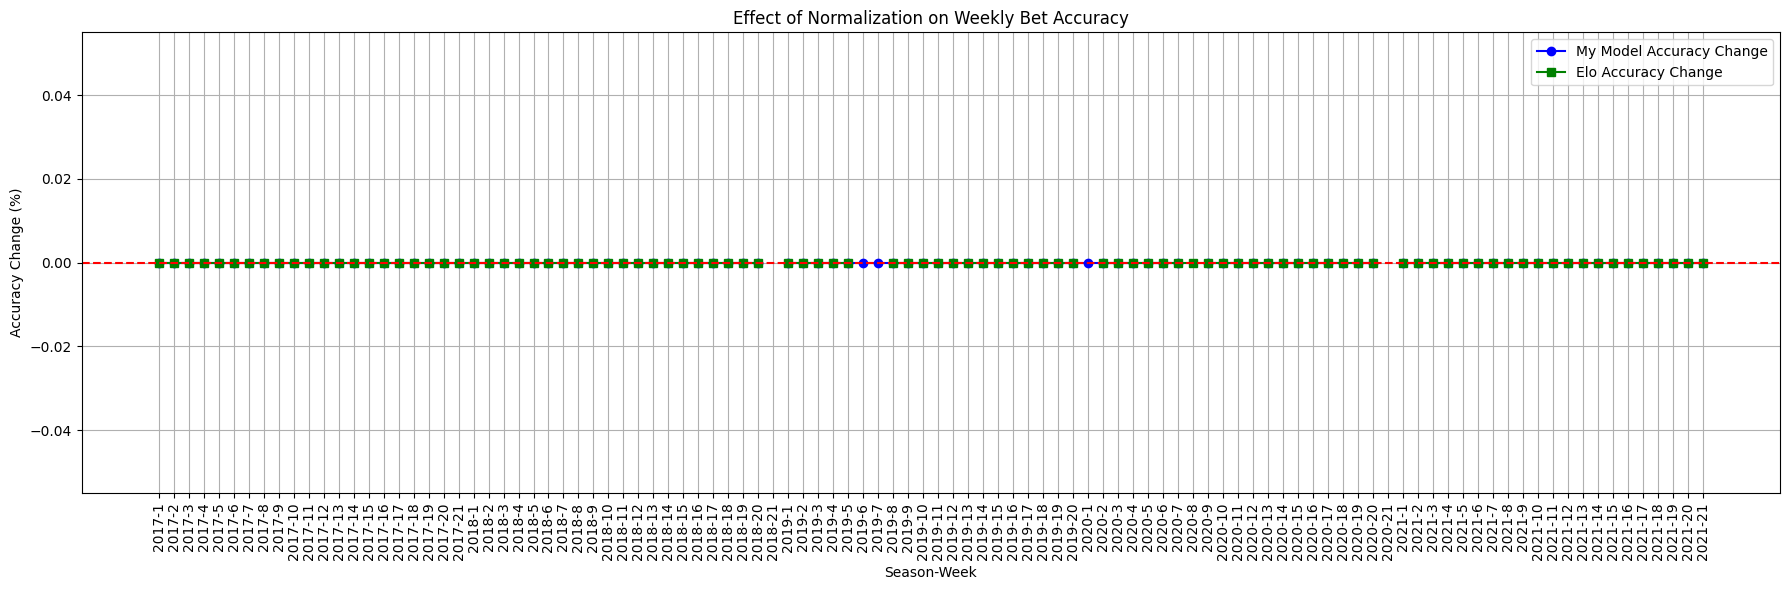

In [49]:
# --- Optional Chart: Accuracy Difference (Normalized - Original) ---
plt.figure(figsize=(18,6))

# calculate differences
comparison['my_model_diff'] = comparison['bet_accuracy_norm'] - comparison['bet_accuracy_old']
comparison['elo_model_diff'] = comparison['elo_bet_accuracy_norm'] - comparison['elo_bet_accuracy_old']

# plot differences
plt.plot(comparison['season_week'], comparison['my_model_diff'], label='My Model Accuracy Change', marker='o', color='blue')
plt.plot(comparison['season_week'], comparison['elo_model_diff'], label='Elo Accuracy Change', marker='s', color='green')

plt.xticks(rotation=90)
plt.xlabel('Season-Week')
plt.ylabel('Accuracy Change (%)')
plt.title('Effect of Normalization on Weekly Bet Accuracy')
plt.axhline(0, color='red', linestyle='--')  # reference line for no change
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [50]:
# calculate differences
comparison['my_model_diff'] = comparison['bet_accuracy_norm'] - comparison['bet_accuracy_old']
comparison['elo_model_diff'] = comparison['elo_bet_accuracy_norm'] - comparison['elo_bet_accuracy_old']

# summary statistics for My Model
my_model_stats = {
    'mean_accuracy_original': comparison['bet_accuracy_old'].mean(),
    'mean_accuracy_normalized': comparison['bet_accuracy_norm'].mean(),
    'std_accuracy_original': comparison['bet_accuracy_old'].std(),
    'std_accuracy_normalized': comparison['bet_accuracy_norm'].std(),
    'average_change': comparison['my_model_diff'].mean(),
    'weeks_improved': (comparison['my_model_diff'] > 0).sum(),
    'weeks_worsened': (comparison['my_model_diff'] < 0).sum()
}

# summary statistics for Elo Model
elo_model_stats = {
    'mean_accuracy_original': comparison['elo_bet_accuracy_old'].mean(),
    'mean_accuracy_normalized': comparison['elo_bet_accuracy_norm'].mean(),
    'std_accuracy_original': comparison['elo_bet_accuracy_old'].std(),
    'std_accuracy_normalized': comparison['elo_bet_accuracy_norm'].std(),
    'average_change': comparison['elo_model_diff'].mean(),
    'weeks_improved': (comparison['elo_model_diff'] > 0).sum(),
    'weeks_worsened': (comparison['elo_model_diff'] < 0).sum()
}

print("My Model Summary:\n", my_model_stats)
print("\nElo Model Summary:\n", elo_model_stats)


My Model Summary:
 {'mean_accuracy_original': np.float64(71.73089108910891), 'mean_accuracy_normalized': np.float64(69.66173076923077), 'std_accuracy_original': np.float64(26.074818699235855), 'std_accuracy_normalized': np.float64(28.383694055522277), 'average_change': np.float64(0.0), 'weeks_improved': np.int64(0), 'weeks_worsened': np.int64(0)}

Elo Model Summary:
 {'mean_accuracy_original': np.float64(68.63777777777777), 'mean_accuracy_normalized': np.float64(65.33788461538461), 'std_accuracy_original': np.float64(26.22518724493204), 'std_accuracy_normalized': np.float64(29.53092171316831), 'average_change': np.float64(0.0), 'weeks_improved': np.int64(0), 'weeks_worsened': np.int64(0)}


In [45]:

# save model as pkl file for weekly predictions
pkl_filename = "NFLMoneyLine_model1.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)